In [1]:
!pip install ipyleaflet ipywidgets geemap
!jupyter nbextension enable --py widgetsnbextension

  Using cached ipyleaflet-0.20.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached branca-0.8.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached jupyter_leaflet-0.20.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached bqplot-0.12.45-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached eerepr-0.1.2-py3-none-any.whl.metadata (4.2 kB)
  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached geocoder-1.38.1-py2.py3-none-any.whl.metadata (14 kB)
  Using cached ipyevents-2.0.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached ipyfilechooser-0.6.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached pyperclip-1.11.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached pyshp-3.0.2.post1-py3-none-any.whl.metadata (64 kB)
  Using cached python_box-7.3.2-cp313-cp313-macosx_10_13_universal2.whl.metadata (8.0 kB)
  Using cached httplib2-0.31.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached uritemplate-4.2.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached proto_plus-1.26.1

In [2]:
# ===============================================================
# 🛰️ Landsat 8/9 Level-1 (TOA) — Austin, TX — July–August 2025
# Google Earth Engine (Python API version)
# ===============================================================

import ee
import geemap

# ---------------------------------------------------------------
# 1️⃣ Authenticate & Initialize
# ---------------------------------------------------------------
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [ ]:
# ---------------------------------------------------------------
# 1️⃣ Setup
# ---------------------------------------------------------------
import ee, geemap
ee.Initialize()

# ---------------------------------------------------------------
# 2️⃣ Define AOI and Time Range
# ---------------------------------------------------------------
aoi = ee.Geometry.Rectangle([-98.05, 30.10, -97.50, 30.55])
start = '2025-07-01'
end   = '2025-08-31'

# ---------------------------------------------------------------
# 3️⃣ Load Landsat 8 + 9 TOA Collection
# ---------------------------------------------------------------
col8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
col9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA')

col = (col8.merge(col9)
          .filterBounds(aoi)
          .filterDate(start, end)
          .sort('CLOUD_COVER'))

print('Number of scenes:', col.size().getInfo())

# Select the least cloudy scene
img = col.first()
print('Selected scene ID:', img.get('LANDSAT_PRODUCT_ID').getInfo())
print('Acquired on:', ee.Date(img.get('DATE_ACQUIRED')).format('YYYY-MM-dd').getInfo())
print('Cloud cover (%):', img.get('CLOUD_COVER').getInfo())
print('Available bands:', img.bandNames().getInfo())

# ---------------------------------------------------------------
# 4️⃣ Compute Brightness Temperature (Kelvin)
# ---------------------------------------------------------------
def compute_bt(image):
    if 'B10' in image.bandNames().getInfo():
        radiance = image.select('B10')
        K1, K2 = 774.8853, 1321.0789
        bt = radiance.expression('K2 / log(K1 / L + 1)', {'K1': K1, 'K2': K2, 'L': radiance})
        bt = bt.rename('BT_K')
        return image.addBands(bt)
    else:
        return image

img = compute_bt(img)

# ---------------------------------------------------------------
# 5️⃣ Normalize Reflectance Bands (0–1 scaling)
# ---------------------------------------------------------------
def normalize_band(image, band_name):
    band = image.select(band_name)
    # Clip reflectance to [0.02, 0.4] for visible/NIR; to [0.03, 0.6] for SWIR
    if band_name in ['B6', 'B7']:
        band = band.unitScale(0.03, 0.6)
    else:
        band = band.unitScale(0.02, 0.4)
    return band.clamp(0, 1).rename(band_name)

reflective_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Build a normalized image by concatenating each band
normalized_list = [normalize_band(img, b) for b in reflective_bands]
img_norm = ee.Image.cat(normalized_list)

# Add normalized bands back (overwrite originals)
img = img.addBands(img_norm, overwrite=True)

# ---------------------------------------------------------------
# 6️⃣ Derived Index (NDVI)
# ---------------------------------------------------------------
ndvi = img.normalizedDifference(['B5', 'B4']).rename('NDVI')
img = img.addBands(ndvi)

# ---------------------------------------------------------------
# 7️⃣ Visualization Check
# ---------------------------------------------------------------
Map = geemap.Map(center=[30.30, -97.75], zoom=11)
Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 0.03, 'max': 0.4}, 'RGB (TOA)')
if 'BT_K' in img.bandNames().getInfo():
    Map.addLayer(img.select('BT_K'), {'min': 290, 'max': 310, 'palette': ['blue', 'cyan', 'green', 'yellow', 'red']}, 'BT (K)')
Map.addLayer(img.select('NDVI'), {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}, 'NDVI')
Map.addLayer(aoi, {}, 'AOI', False)
Map

# ---------------------------------------------------------------
# 8️⃣ Export Each Band Separately
# ---------------------------------------------------------------
export_bands = img.bandNames().getInfo()
print("Bands to export:", export_bands)

for band_name in export_bands:
    single_band = img.select(band_name).clip(aoi)
    description = f"Austin_{band_name}_2025Aug"
    file_prefix = f"Austin_{band_name}_2025Aug"

    task = ee.batch.Export.image.toDrive(
        image=single_band.toFloat(),
        description=description,
        folder='EarthEngineExports',
        fileNamePrefix=file_prefix,
        region=aoi,
        scale=30,
        crs='EPSG:32614',
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Export started for {band_name} — check https://code.earthengine.google.com/tasks")

print("✅ All single-band export tasks submitted.")


Number of scenes: 7
Selected scene ID: LC09_L1TP_027039_20250808_20250808_02_T1
Acquired on: 2025-08-08
Cloud cover (%): 0.01
Available bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA']
Bands to export: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA', 'BT_K', 'NDVI']
🚀 Export started for B1 — check https://code.earthengine.google.com/tasks
🚀 Export started for B2 — check https://code.earthengine.google.com/tasks
🚀 Export started for B3 — check https://code.earthengine.google.com/tasks
🚀 Export started for B4 — check https://code.earthengine.google.com/tasks
🚀 Export started for B5 — check https://code.earthengine.google.com/tasks
🚀 Export started for B6 — check https://code.earthengine.google.com/tasks
🚀 Export started for B7 — check https://code.earthengine.google.com/tasks
🚀 Export started for B8 — check https://code.earthengine.googl

Number of scenes: 4
Scene ID: LC09_L2SP_027039_20250808_20250809_02_T1
Date: 2025-08-08
Cloud cover (%): 0.01

🌡️ Land Surface Temperature (Kelvin) Stats:
  LST_K_max: 333.57
  LST_K_mean: 319.91
  LST_K_min: 299.69
  LST_K_stdDev: 3.68


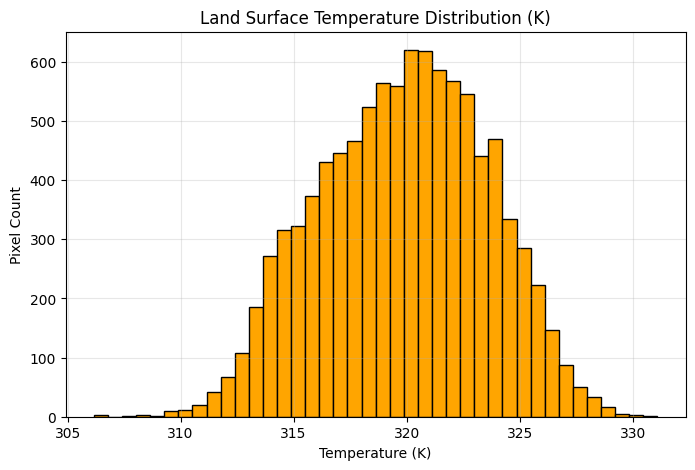

✅ Export started! Check https://code.earthengine.google.com/tasks for progress.


In [ ]:
# ---------------------------------------------------------------
# 1️⃣ Setup
# ---------------------------------------------------------------
import ee, geemap
import matplotlib.pyplot as plt
import numpy as np

ee.Initialize()

# ---------------------------------------------------------------
# 2️⃣ Define AOI and Time Range
# ---------------------------------------------------------------
aoi = ee.Geometry.Rectangle([-98.05, 30.10, -97.50, 30.55])
start = '2025-07-01'
end   = '2025-08-31'

# ---------------------------------------------------------------
# 3️⃣ Load Landsat 9 Level-2 Collection (Surface Reflectance & Temperature)
# ---------------------------------------------------------------
col9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate(start, end) \
    .sort('CLOUD_COVER')

print('Number of scenes:', col9.size().getInfo())

# Select least-cloudy scene
img = col9.first()
print('Scene ID:', img.get('LANDSAT_PRODUCT_ID').getInfo())
print('Date:', ee.Date(img.get('DATE_ACQUIRED')).format('YYYY-MM-dd').getInfo())
print('Cloud cover (%):', img.get('CLOUD_COVER').getInfo())

# ---------------------------------------------------------------
# 4️⃣ Convert Surface Temperature (ST_B10) to Kelvin and °C
# ---------------------------------------------------------------
# ST_B10 is scaled: LST(K) = DN * 0.00341802 + 149.0
lstK = img.select('ST_B10').multiply(0.00341802).add(149.0).rename('LST_K')
lstC = lstK.subtract(273.15).rename('LST_C')

# ---------------------------------------------------------------
# 5️⃣ Cloud, Shadow, and Water Masking (QA_PIXEL bits)
# ---------------------------------------------------------------
qa = img.select('QA_PIXEL')
cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)
shadow_mask = qa.bitwiseAnd(1 << 4).eq(0)
water_mask  = qa.bitwiseAnd(1 << 7).eq(0)
mask = cloud_mask.And(shadow_mask).And(water_mask)

lstK_masked = lstK.updateMask(mask).clip(aoi)
lstC_masked = lstC.updateMask(mask).clip(aoi)

# ---------------------------------------------------------------
# 6️⃣ Compute Summary Statistics
# ---------------------------------------------------------------
stats = lstK_masked.reduceRegion(
    reducer=ee.Reducer.minMax()
             .combine(ee.Reducer.mean(), '', True)
             .combine(ee.Reducer.stdDev(), '', True),
    geometry=aoi,
    scale=30,
    bestEffort=True
).getInfo()

print('\n🌡️ Land Surface Temperature (Kelvin) Stats:')
for k, v in stats.items():
    print(f'  {k}: {v:.2f}')

# ---------------------------------------------------------------
# 7️⃣ Histogram (client-side sampling)
# ---------------------------------------------------------------
samples = lstK_masked.sample(region=aoi, scale=30, numPixels=10000)
vals = np.array(samples.aggregate_array('LST_K').getInfo())

plt.figure(figsize=(8,5))
plt.hist(vals, bins=40, color='orange', edgecolor='black')
plt.title('Land Surface Temperature Distribution (K)')
plt.xlabel('Temperature (K)')
plt.ylabel('Pixel Count')
plt.grid(alpha=0.3)
plt.show()

# ---------------------------------------------------------------
# 8️⃣ Visualize Map
# ---------------------------------------------------------------
Map = geemap.Map(center=[30.30, -97.75], zoom=11)
vis_lst = {'min': 290, 'max': 315,
           'palette': ['blue','cyan','green','yellow','red']}
Map.addLayer(lstK_masked, vis_lst, 'LST (K, masked)')
Map.addLayer(aoi, {}, 'AOI', False)
Map.addLayerControl()
Map

# ---------------------------------------------------------------
# 9️⃣ Export LST Band as GeoTIFF
# ---------------------------------------------------------------
task = ee.batch.Export.image.toDrive(
    image=lstK_masked.toFloat(),
    description='Austin_Land_Surface_Temperature_2025Aug',
    folder='EarthEngineExports',           # optional folder in Drive
    fileNamePrefix='Land_surface_temperature',
    region=aoi,
    scale=30,
    crs='EPSG:32614',                     # UTM Zone 14N (Austin)
    maxPixels=1e13
)

task.start()
print("✅ Export started! Check https://code.earthengine.google.com/tasks for progress.")


File: /Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/purple_air/austin_lt_dur_2016_2024.tif
CRS: EPSG:4326
Bands: 1
Dtype: ('int16',)
Descriptions: ('dur',)


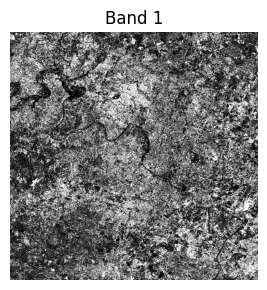

Less than 3 bands — RGB composite not available.


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Path to your raster ---
tif_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/purple_air/austin_lt_dur_2016_2024.tif"

# --- Open and inspect ---
with rasterio.open(tif_path) as src:
    arr = src.read()         # shape: (bands, height, width)
    meta = src.meta
    band_count = src.count
    print(f"File: {tif_path}")
    print(f"CRS: {src.crs}")
    print(f"Bands: {band_count}")
    print(f"Dtype: {src.dtypes}")
    print(f"Descriptions: {src.descriptions}")

# --- Percent stretch function (for display only) ---
def stretch_2_98(band):
    b = band.astype(float)
    mask = ~np.isnan(b)
    lo, hi = np.percentile(b[mask], (2, 98))
    stretched = np.clip(b, lo, hi)
    return (stretched - lo) / (hi - lo + 1e-9)

# --- Plot all bands individually ---
ncols = min(4, band_count)
nrows = math.ceil(band_count / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.array(axes).reshape(-1)

for i in range(band_count):
    band = arr[i]
    axes[i].imshow(stretch_2_98(band), cmap="gray")
    axes[i].set_title(f"Band {i+1}")
    axes[i].axis("off")

# Turn off unused subplots
for j in range(band_count, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# --- Show RGB composite if 3 or more bands ---
if band_count >= 3:
    # Choose bands for RGB (adjust to your dataset)
    # Landsat 8/9 → Red=B4, Green=B3, Blue=B2  (indices are 3,2,1)
    rgb_indices = [3, 2, 1] if band_count >= 4 else [0, 1, 2]

    # Ensure we don’t exceed number of bands
    rgb_indices = [i for i in rgb_indices if i < band_count]

    rgb = np.dstack([stretch_2_98(arr[i-1]) if i>0 else stretch_2_98(arr[i]) for i in rgb_indices])
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb)
    plt.title(f"RGB Composite (Bands {', '.join(str(i) for i in rgb_indices)})")
    plt.axis("off")
    plt.show()
else:
    print("Less than 3 bands — RGB composite not available.")


CRS: EPSG:32614
Range (min–max): 299.69 – 333.57 K


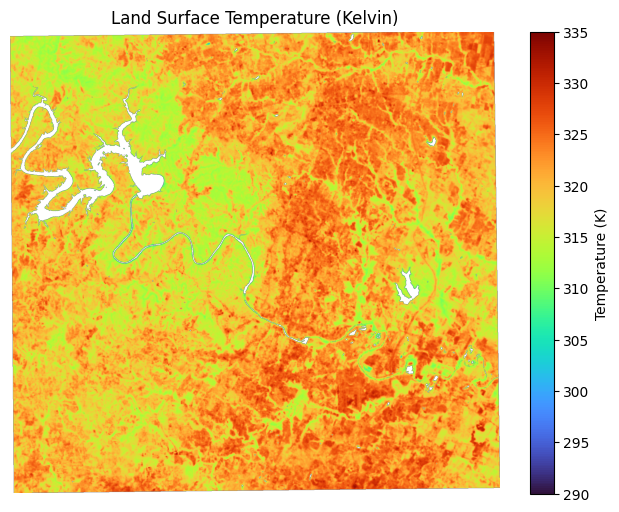

✅ Interactive map saved as 'LST_map.html'. Open it in your browser.



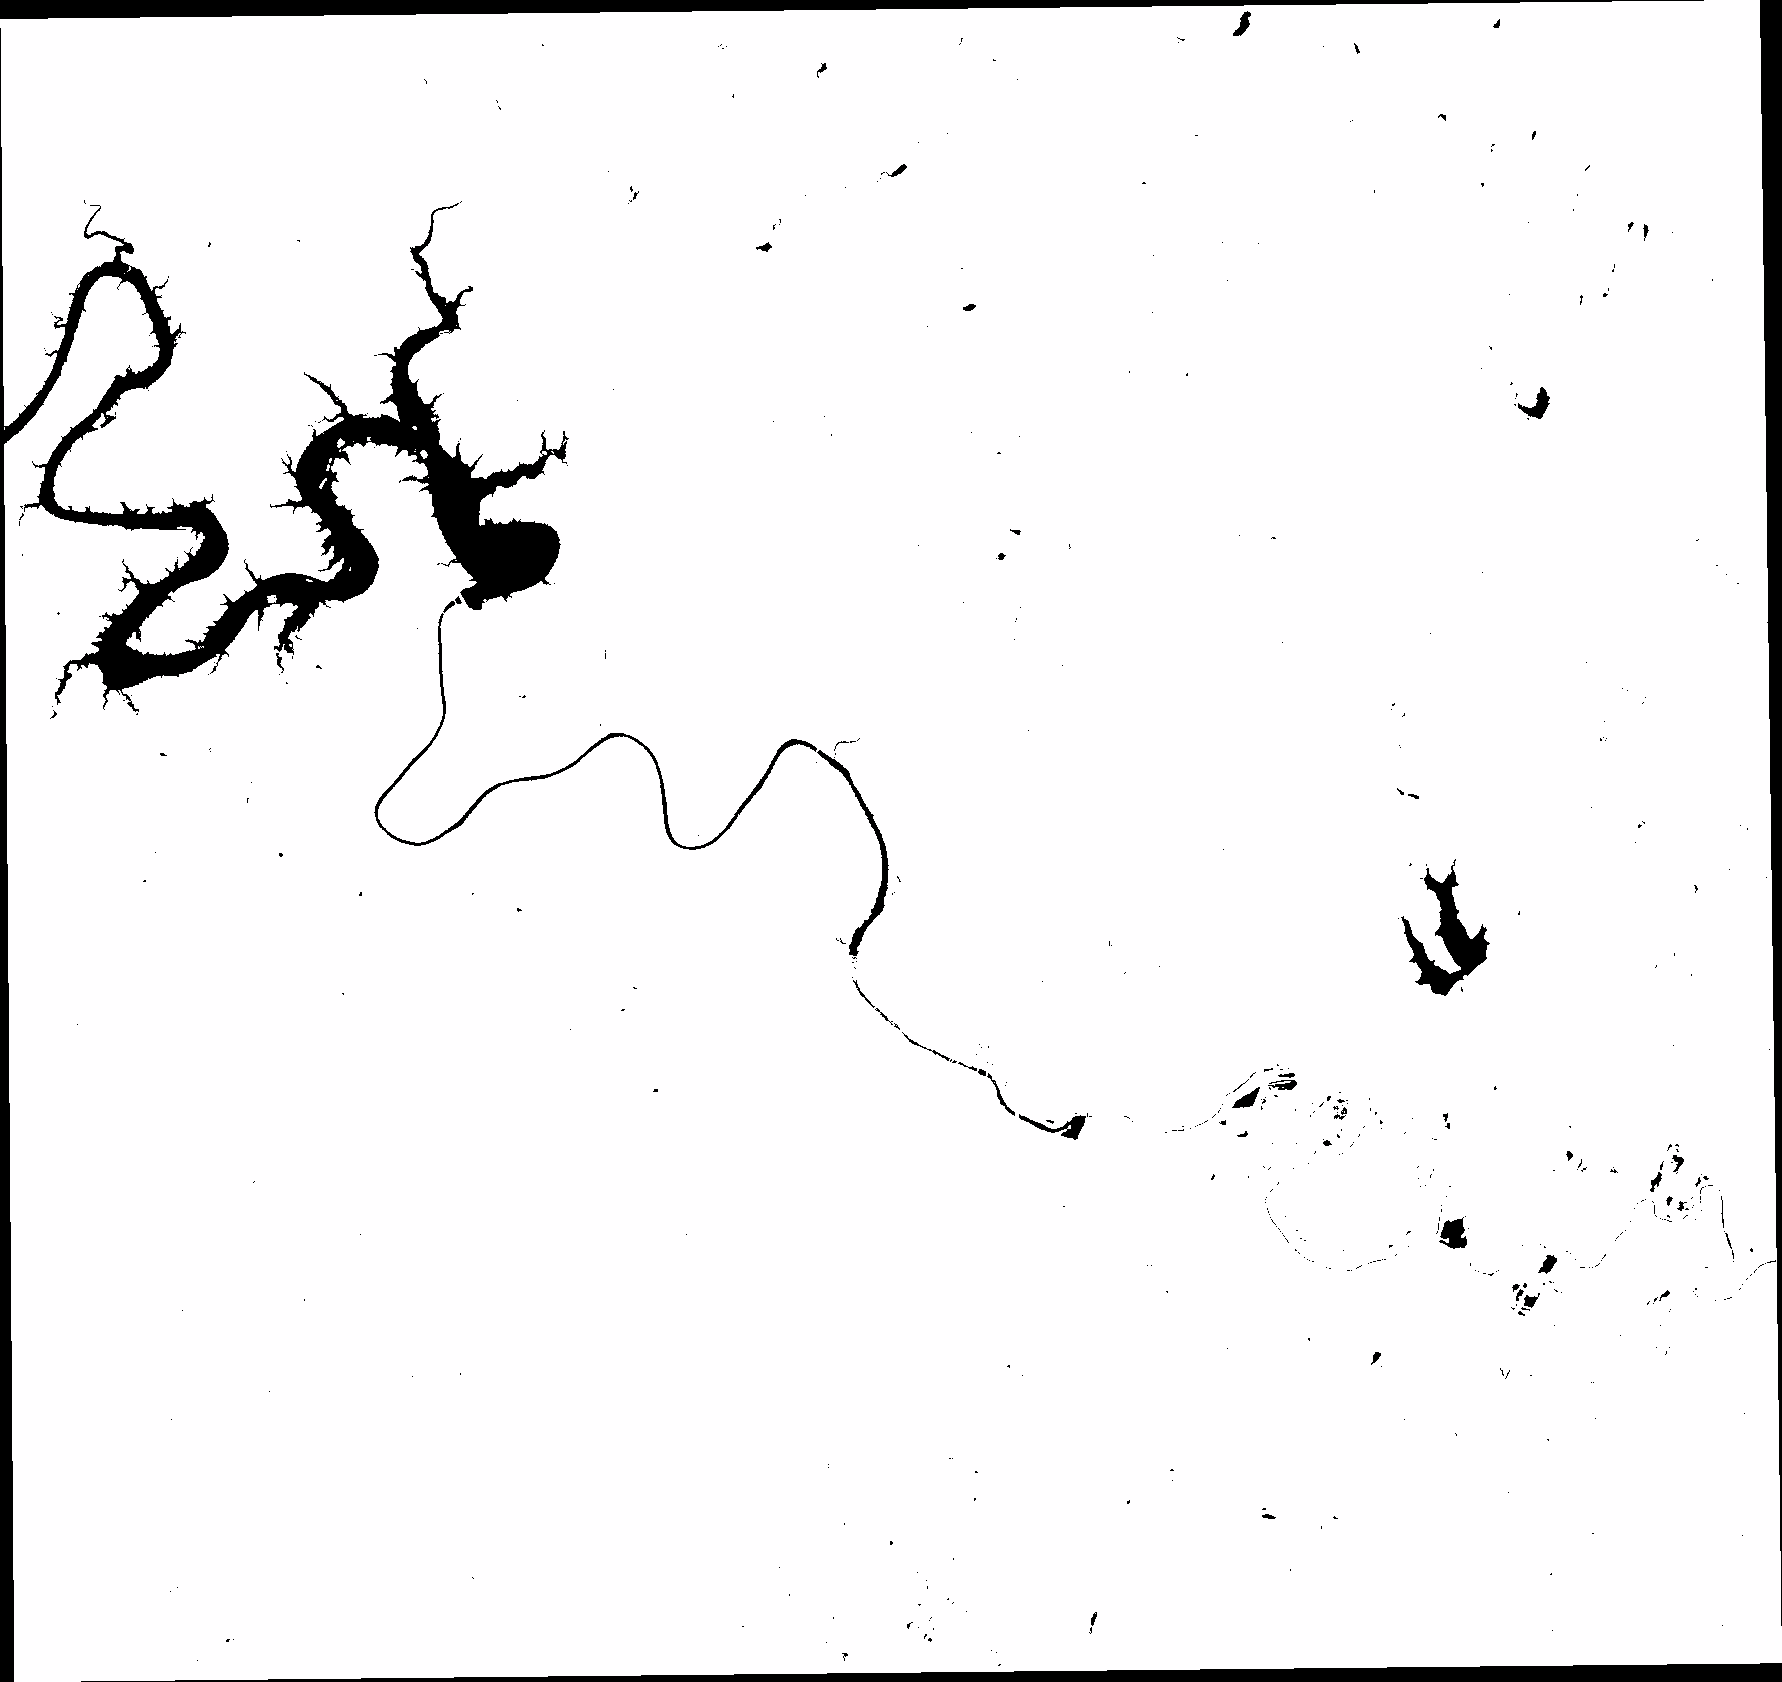

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import raster_layers

# ---------------------------------------------------------------
# 1️⃣ Load the LST GeoTIFF
# ---------------------------------------------------------------
tif_path = "Land_surface_temperature.tif"

with rasterio.open(tif_path) as src:
    lst = src.read(1)
    bounds = src.bounds
    crs = src.crs
    transform = src.transform
    print(f"CRS: {crs}")
    print(f"Range (min–max): {np.nanmin(lst):.2f} – {np.nanmax(lst):.2f} K")

# ---------------------------------------------------------------
# 2️⃣ Plot a static map (matplotlib)
# ---------------------------------------------------------------
plt.figure(figsize=(8, 6))
im = plt.imshow(lst, cmap="turbo", vmin=290, vmax=335)
plt.title("Land Surface Temperature (Kelvin)")
plt.colorbar(im, label="Temperature (K)")
plt.axis("off")
plt.show()

# ---------------------------------------------------------------
# 3️⃣ Create an interactive map (folium)
# ---------------------------------------------------------------
# Compute center coordinates
center_lat = (bounds.top + bounds.bottom) / 2
center_lon = (bounds.left + bounds.right) / 2

# Create folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

# Add the LST raster as an overlay
raster_layers.ImageOverlay(
    image=lst,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    colormap=lambda x: (plt.cm.turbo(x)[0], plt.cm.turbo(x)[1], plt.cm.turbo(x)[2], 0.8),
    opacity=0.8
).add_to(m)

folium.LayerControl().add_to(m)

m.save("LST_map.html")
print("✅ Interactive map saved as 'LST_map.html'. Open it in your browser.")
m


/opt/miniconda3/envs/alphaearth/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


Valid pixels: 2870084
✅ Saved weighted samples to LST_samples_weighted_500.geojson


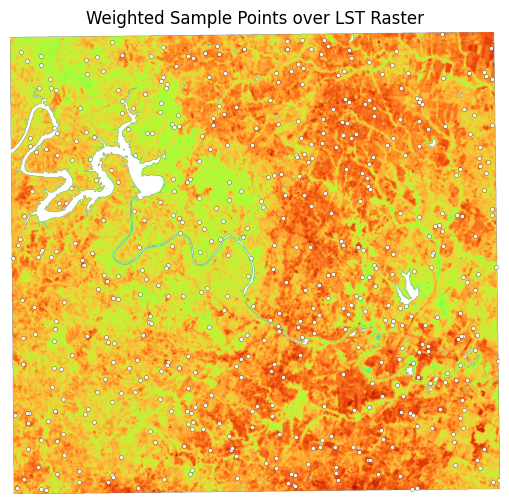

In [1]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1️⃣ Load raster
# ---------------------------------------------------------------
tif_path = "Land_surface_temperature.tif"
with rasterio.open(tif_path) as src:
    lst = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

# Mask invalid values
mask = np.isfinite(lst)
valid_vals = lst[mask]
print(f"Valid pixels: {mask.sum()}")

# ---------------------------------------------------------------
# 2️⃣ Compute sampling weights (hotter areas = higher weight)
# ---------------------------------------------------------------
# Shift temperatures to positive range
temp_shift = valid_vals - np.nanmin(valid_vals)
# Add small constant to keep low temps from being zero-weight
weights = temp_shift + 1  
# Normalize to sum to 1
weights = weights / np.sum(weights)

# ---------------------------------------------------------------
# 3️⃣ Choose 500 weighted random pixels
# ---------------------------------------------------------------
n_samples = 500
flat_indices = np.arange(mask.size)
valid_indices = flat_indices[mask.flatten()]
sample_indices = np.random.choice(valid_indices, size=n_samples, replace=False, p=weights)

# Convert flat index → row, col
rows, cols = np.unravel_index(sample_indices, lst.shape)

# Get x, y coordinates
xs, ys = rasterio.transform.xy(transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)
temps = lst[rows, cols]

# ---------------------------------------------------------------
# 4️⃣ Create GeoDataFrame
# ---------------------------------------------------------------
gdf = gpd.GeoDataFrame(
    {'x': xs, 'y': ys, 'temperature_K': temps},
    geometry=[Point(x, y) for x, y in zip(xs, ys)],
    crs=crs
)

# Save for later ML
out_path = "LST_samples_weighted_500.geojson"
gdf.to_file(out_path, driver="GeoJSON")
print(f"✅ Saved weighted samples to {out_path}")

# ---------------------------------------------------------------
# 5️⃣ Quick visualization
# ---------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(lst, cmap='turbo', vmin=290, vmax=335)
plt.scatter(cols, rows, s=8, c='white', edgecolor='black', linewidth=0.2)
plt.title("Weighted Sample Points over LST Raster")
plt.axis("off")
plt.show()


Valid pixels: 2870084 | Mean Temp: 319.92 K
✅ Generated 500 adaptive samples
✅ Saved adaptive samples to LST_samples_adaptive_500.geojson


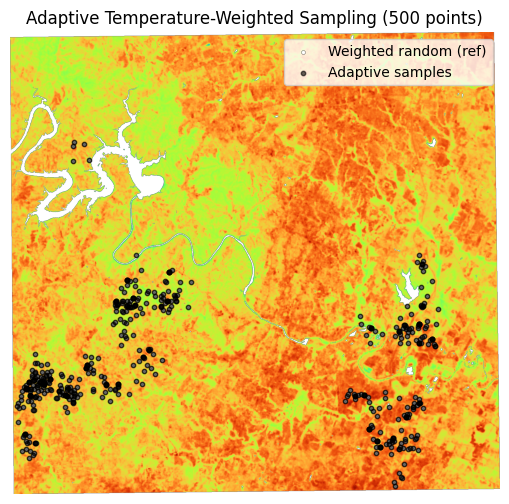

In [2]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------------
# 1️⃣ Load raster
# ---------------------------------------------------------------
tif_path = "Land_surface_temperature.tif"
with rasterio.open(tif_path) as src:
    lst = src.read(1)
    transform = src.transform
    crs = src.crs
    height, width = lst.shape

mask = np.isfinite(lst)
valid_rows, valid_cols = np.where(mask)
valid_vals = lst[valid_rows, valid_cols]

print(f"Valid pixels: {mask.sum()} | Mean Temp: {np.nanmean(valid_vals):.2f} K")

# ---------------------------------------------------------------
# 2️⃣ Parameters for adaptive sampling
# ---------------------------------------------------------------
n_samples = 500
base_step = 30         # pixels; roughly equal to raster cell size
min_step = 1
max_step = 60
alpha = 2.0            # controls sensitivity to temperature change
random.seed(42)
np.random.seed(42)

# Start from a random valid location
start_idx = np.random.choice(len(valid_rows))
r, c = valid_rows[start_idx], valid_cols[start_idx]
current_temp = lst[r, c]

samples = [(r, c, current_temp)]

# ---------------------------------------------------------------
# 3️⃣ Iteratively sample points (adaptive step size)
# ---------------------------------------------------------------
for i in range(1, n_samples):
    # Decide step size based on recent temperature trend
    if len(samples) > 5:
        recent_temps = [s[2] for s in samples[-5:]]
        mean_recent = np.mean(recent_temps)
        # hotter than recent avg → move closer; cooler → move farther
        ratio = np.clip((mean_recent - current_temp) / 5.0, -1, 1)
        step = int(np.clip(base_step * (1 + alpha * ratio), min_step, max_step))
    else:
        step = base_step

    # Random direction
    angle = np.random.uniform(0, 2*np.pi)
    dr = int(step * np.sin(angle))
    dc = int(step * np.cos(angle))
    nr, nc = r + dr, c + dc

    # keep within raster bounds
    if 0 <= nr < height and 0 <= nc < width and mask[nr, nc]:
        r, c = nr, nc
        current_temp = lst[r, c]
        samples.append((r, c, current_temp))
    else:
        # if move invalid, pick another random valid pixel
        rand_idx = np.random.choice(len(valid_rows))
        r, c = valid_rows[rand_idx], valid_cols[rand_idx]
        current_temp = lst[r, c]
        samples.append((r, c, current_temp))

print(f"✅ Generated {len(samples)} adaptive samples")

# ---------------------------------------------------------------
# 4️⃣ Convert pixel → coordinates
# ---------------------------------------------------------------
rows, cols, temps = zip(*samples)
xs, ys = rasterio.transform.xy(transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)

# ---------------------------------------------------------------
# 5️⃣ Create GeoDataFrame and export
# ---------------------------------------------------------------
gdf = gpd.GeoDataFrame(
    {'x': xs, 'y': ys, 'temperature_K': temps},
    geometry=[Point(x, y) for x, y in zip(xs, ys)],
    crs=crs
)

out_path = "LST_samples_adaptive_500.geojson"
gdf.to_file(out_path, driver="GeoJSON")
print(f"✅ Saved adaptive samples to {out_path}")

# ---------------------------------------------------------------
# 6️⃣ Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(lst, cmap="turbo", vmin=290, vmax=335)
plt.scatter(cols, rows, s=8, c='white', edgecolor='black', linewidth=0.2, label='Weighted random (ref)')
plt.scatter([s[1] for s in samples], [s[0] for s in samples],
            s=10, c='black', alpha=0.6, label='Adaptive samples')
plt.title("Adaptive Temperature-Weighted Sampling (500 points)")
plt.legend()
plt.axis("off")
plt.show()


In [6]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------------
# 1️⃣ Load raster
# ---------------------------------------------------------------
tif_path = "Land_surface_temperature.tif"
with rasterio.open(tif_path) as src:
    lst = src.read(1)
    transform = src.transform
    crs = src.crs
    height, width = lst.shape

mask = np.isfinite(lst)
valid_rows, valid_cols = np.where(mask)
valid_vals = lst[valid_rows, valid_cols]
print(f"Valid pixels: {mask.sum()} | Mean Temp: {np.nanmean(valid_vals):.2f} K")

# ---------------------------------------------------------------
# 2️⃣ Parameters
# ---------------------------------------------------------------
n_random = 250
n_adaptive = 250
base_step = 60
min_step, max_step = 20, 120
alpha = 1.5  # temperature sensitivity
random.seed(42)
np.random.seed(42)

# ---------------------------------------------------------------
# 3️⃣ Random samples (uniform)
# ---------------------------------------------------------------
rand_idx = np.random.choice(len(valid_rows), size=n_random, replace=False)
rand_samples = [(valid_rows[i], valid_cols[i], lst[valid_rows[i], valid_cols[i]]) for i in rand_idx]

# ---------------------------------------------------------------
# 4️⃣ Adaptive samples (temperature-sensitive step)
# ---------------------------------------------------------------
start_idx = np.random.choice(len(valid_rows))
r, c = valid_rows[start_idx], valid_cols[start_idx]
current_temp = lst[r, c]
adaptive_samples = [(r, c, current_temp)]

for i in range(1, n_adaptive):
    if len(adaptive_samples) > 5:
        recent_temps = [s[2] for s in adaptive_samples[-5:]]
        mean_recent = np.mean(recent_temps)
        ratio = np.clip((mean_recent - current_temp) / 5.0, -1, 1)
        step = int(np.clip(base_step * (1 + alpha * ratio), min_step, max_step))
    else:
        step = base_step

    # random direction
    angle = np.random.uniform(0, 2*np.pi)
    dr = int(step * np.sin(angle))
    dc = int(step * np.cos(angle))

    nr, nc = r + dr, c + dc
    # if outside bounds → reinitialize from random valid pixel
    if not (0 <= nr < height and 0 <= nc < width and mask[nr, nc]):
        rand_idx = np.random.choice(len(valid_rows))
        nr, nc = valid_rows[rand_idx], valid_cols[rand_idx]

    # small random jitter (avoid overlapping)
    nr = np.clip(nr + np.random.randint(-3, 4), 0, height - 1)
    nc = np.clip(nc + np.random.randint(-3, 4), 0, width - 1)

    r, c = nr, nc
    current_temp = lst[r, c]
    adaptive_samples.append((r, c, current_temp))

print(f"✅ Generated {len(rand_samples)} random + {len(adaptive_samples)} adaptive samples")

# ---------------------------------------------------------------
# 5️⃣ Merge and convert to GeoDataFrame
# ---------------------------------------------------------------
samples = rand_samples + adaptive_samples
rows, cols, temps = zip(*samples)
xs, ys = rasterio.transform.xy(transform, rows, cols)

gdf = gpd.GeoDataFrame(
    {'x': xs, 'y': ys, 'temperature_K': temps,
     'type': ['random']*n_random + ['adaptive']*n_adaptive},
    geometry=[Point(x, y) for x, y in zip(xs, ys)],
    crs=crs
)

out_path = "LST_samples_mixed_500.geojson"
gdf.to_file(out_path, driver="GeoJSON")
print(f"✅ Saved combined samples to {out_path}")

# ---------------------------------------------------------------
# 6️⃣ Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(lst, cmap='turbo', vmin=290, vmax=335)
plt.scatter(
    [s[1] for s in rand_samples], [s[0] for s in rand_samples],
    s=10, c='white', edgecolor='black', linewidth=0.3, label='Random (250)'
)
plt.scatter(
    [s[1] for s in adaptive_samples], [s[0] for s in adaptive_samples],
    s=12, c='black', alpha=0.7, label='Adaptive (250)'
)
plt.title("Balanced Temperature-Weighted Sampling (500 points)")
plt.legend()
plt.axis("off")
plt.show()


Valid pixels: 2870084 | Mean Temp: 319.92 K


ValueError: cannot convert float NaN to integer

Valid pixels: 2870084 | Mean Temp: 319.92 K
✅ Generated 250 random + 250 adaptive samples
✅ Saved combined samples to LST_samples_mixed_500.geojson


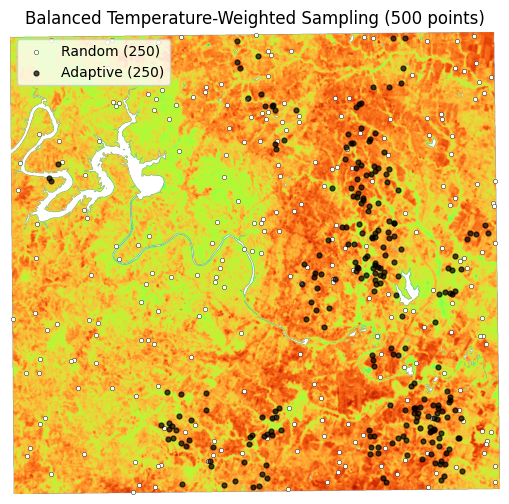

In [7]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------------
# 1️⃣ Load raster
# ---------------------------------------------------------------
tif_path = "Land_surface_temperature.tif"
with rasterio.open(tif_path) as src:
    lst = src.read(1)
    transform = src.transform
    crs = src.crs
    height, width = lst.shape

mask = np.isfinite(lst)
valid_rows, valid_cols = np.where(mask)
valid_vals = lst[valid_rows, valid_cols]
print(f"Valid pixels: {mask.sum()} | Mean Temp: {np.nanmean(valid_vals):.2f} K")

# ---------------------------------------------------------------
# 2️⃣ Parameters
# ---------------------------------------------------------------
n_random = 250
n_adaptive = 250
base_step = 60
min_step, max_step = 20, 120
alpha = 1.5  # temperature sensitivity
random.seed(42)
np.random.seed(42)

# ---------------------------------------------------------------
# 3️⃣ Random samples (uniform)
# ---------------------------------------------------------------
rand_idx = np.random.choice(len(valid_rows), size=n_random, replace=False)
rand_samples = [(valid_rows[i], valid_cols[i], lst[valid_rows[i], valid_cols[i]]) for i in rand_idx]

# ---------------------------------------------------------------
# 4️⃣ Adaptive samples (temperature-sensitive step)
# ---------------------------------------------------------------
start_idx = np.random.choice(len(valid_rows))
r, c = valid_rows[start_idx], valid_cols[start_idx]
current_temp = lst[r, c]
adaptive_samples = [(r, c, current_temp)]

for i in range(1, n_adaptive):
    # --- handle NaNs robustly ---
    if not np.isfinite(current_temp):
        rand_idx = np.random.choice(len(valid_rows))
        r, c = valid_rows[rand_idx], valid_cols[rand_idx]
        current_temp = lst[r, c]

    # --- compute step size ---
    if len(adaptive_samples) > 5:
        recent_temps = [s[2] for s in adaptive_samples[-5:] if np.isfinite(s[2])]
        if len(recent_temps) == 0:
            step = base_step
        else:
            mean_recent = np.mean(recent_temps)
            ratio = (mean_recent - current_temp) / 5.0
            ratio = np.clip(ratio, -1, 1)
            step = int(np.clip(base_step * (1 + alpha * ratio), min_step, max_step))
    else:
        step = base_step

    # --- pick a direction and move ---
    angle = np.random.uniform(0, 2*np.pi)
    dr = int(step * np.sin(angle))
    dc = int(step * np.cos(angle))
    nr, nc = r + dr, c + dc

    # --- bounds and validity check ---
    if not (0 <= nr < height and 0 <= nc < width and mask[nr, nc]):
        rand_idx = np.random.choice(len(valid_rows))
        nr, nc = valid_rows[rand_idx], valid_cols[rand_idx]

    # --- jitter to avoid perfect alignment ---
    nr = np.clip(nr + np.random.randint(-5, 6), 0, height - 1)
    nc = np.clip(nc + np.random.randint(-5, 6), 0, width - 1)

    r, c = nr, nc
    current_temp = lst[r, c]
    adaptive_samples.append((r, c, current_temp))

print(f"✅ Generated {len(rand_samples)} random + {len(adaptive_samples)} adaptive samples")

# ---------------------------------------------------------------
# 5️⃣ Merge and convert to GeoDataFrame
# ---------------------------------------------------------------
samples = rand_samples + adaptive_samples
rows, cols, temps = zip(*samples)
xs, ys = rasterio.transform.xy(transform, rows, cols)

gdf = gpd.GeoDataFrame(
    {'x': xs, 'y': ys, 'temperature_K': temps,
     'type': ['random']*n_random + ['adaptive']*n_adaptive},
    geometry=[Point(x, y) for x, y in zip(xs, ys)],
    crs=crs
)

out_path = "LST_samples_mixed_500.geojson"
gdf.to_file(out_path, driver="GeoJSON")
print(f"✅ Saved combined samples to {out_path}")

# ---------------------------------------------------------------
# 6️⃣ Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(lst, cmap='turbo', vmin=290, vmax=335)
plt.scatter(
    [s[1] for s in rand_samples], [s[0] for s in rand_samples],
    s=10, c='white', edgecolor='black', linewidth=0.3, label='Random (250)'
)
plt.scatter(
    [s[1] for s in adaptive_samples], [s[0] for s in adaptive_samples],
    s=12, c='black', alpha=0.7, label='Adaptive (250)'
)
plt.title("Balanced Temperature-Weighted Sampling (500 points)")
plt.legend()
plt.axis("off")
plt.show()


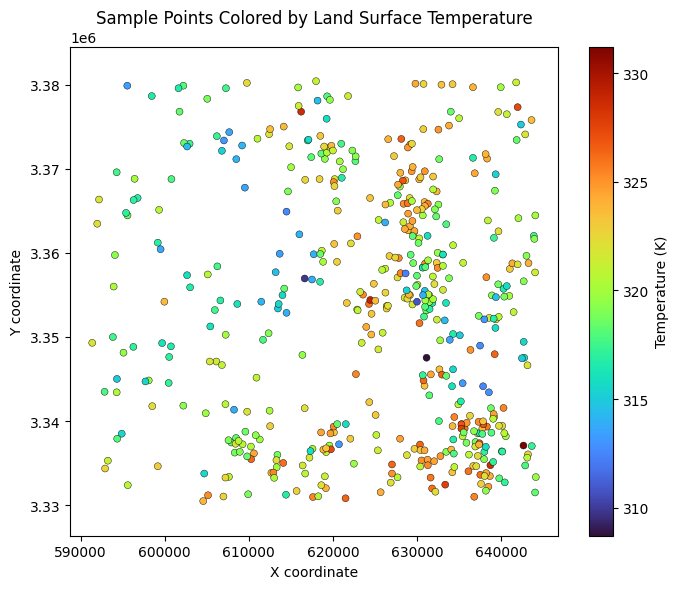

In [12]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Plot sample points (already in gdf)
# ---------------------------------------------------------------
plt.figure(figsize=(7, 6))
sc = plt.scatter(
    gdf["x"], gdf["y"],
    c=gdf["temperature_K"],
    cmap="turbo",
    s=25,
    edgecolor="black",
    linewidth=0.3
)
plt.colorbar(sc, label="Temperature (K)")
plt.title("Sample Points Colored by Land Surface Temperature")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.axis("equal")
plt.tight_layout()
plt.show()


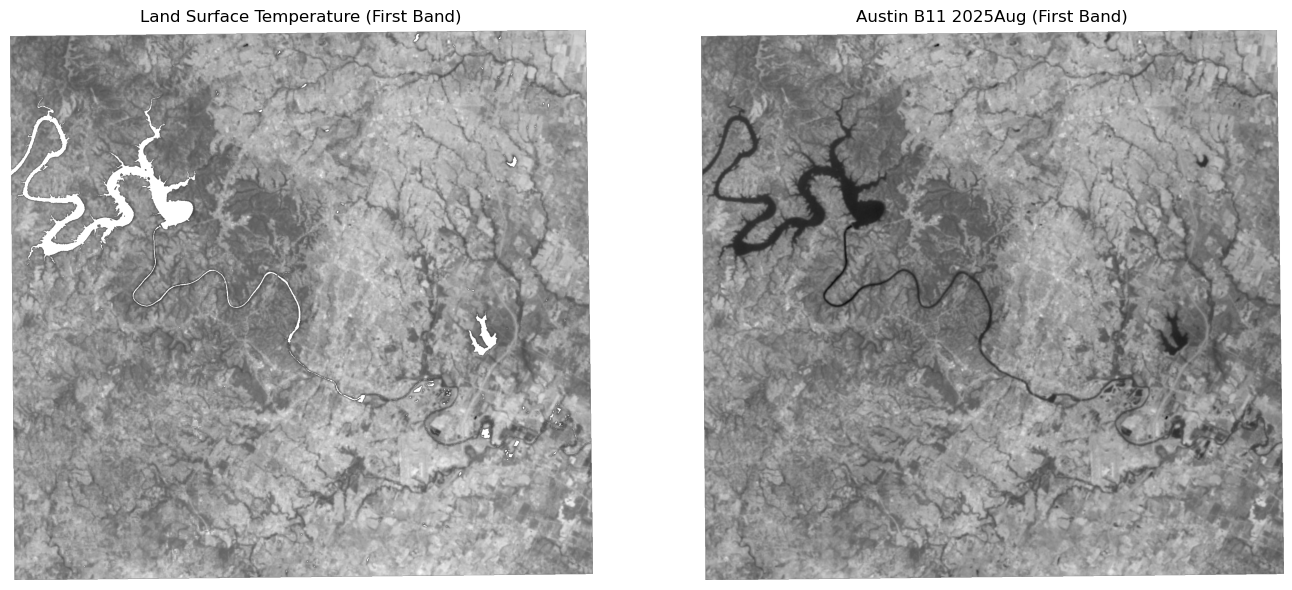

In [11]:
# Show both TIFFs side by side
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

project_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/"
lst_path = project_path + "data/Land_surface_temperature.tif"
B11_path = project_path + "data/Austin_B11_2025Aug.tif"

img = Image.open(lst_path)
img_B11 = Image.open(B11_path)
arr = np.array(img)
arr_B11 = np.array(img_B11)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(arr, cmap="gray")
plt.title("Land Surface Temperature (First Band)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(arr_B11, cmap="gray")
plt.title("Austin B11 2025Aug (First Band)")
plt.axis("off")

plt.tight_layout()
plt.show()

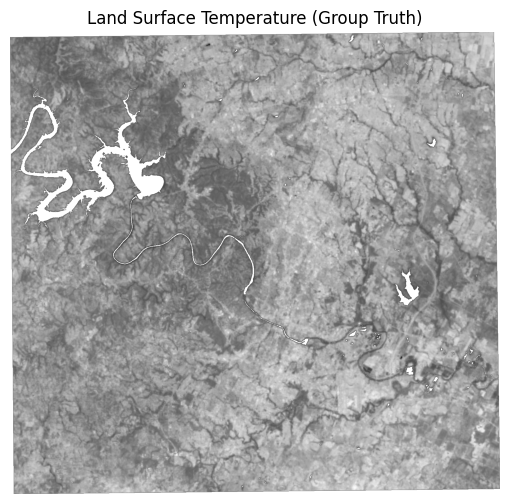

In [1]:
# Show only the Land Surface Temperature TIFF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

project_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/"
lst_path = project_path + "data/Land_surface_temperature.tif"

img = Image.open(lst_path)
arr = np.array(img)

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.title("Land Surface Temperature (Group Truth)")
plt.axis("off")
plt.show()

In [6]:
# Select 500 random samples from img and save coordinates/values in a DataFrame
import numpy as np
import pandas as pd
import rasterio

arr = np.array(img)
with rasterio.open(lst_path) as src:
    transform = src.transform

mask = np.isfinite(arr)
rows, cols = np.where(mask)
np.random.seed(42)
idx = np.random.choice(len(rows), size=500, replace=False)
sample_rows = rows[idx]
sample_cols = cols[idx]
sample_vals = arr[sample_rows, sample_cols]
xs, ys = rasterio.transform.xy(transform, sample_rows, sample_cols)

df = pd.DataFrame({
    "row": sample_rows,
    "col": sample_cols,
    "x": xs,
    "y": ys,
    "land surface temperature": sample_vals
})

df.to_csv("LST_random_samples_500.csv", index=False)
df.head()

row  col         x          y  land surface temperature
0   264  603  609195.0  3372765.0                314.244171
1   725  924  618825.0  3358935.0                320.116333
2   775  467  605115.0  3357435.0                320.670044
3  1014  538  607245.0  3350265.0                319.979614
4    37  539  607275.0  3379575.0                317.559662

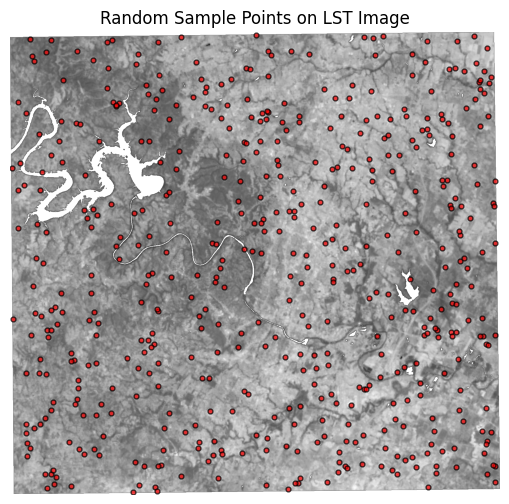

In [7]:
import matplotlib.pyplot as plt

# Plot the image and overlay the sample points
plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.scatter(sample_cols, sample_rows, s=12, c="red", edgecolor="black", alpha=0.7)
plt.title("Random Sample Points on LST Image")
plt.axis("off")
plt.show()